# EXAMPLE : Using aweSOM to segment decaying plasma turbulence simulation
For more details about the data, see Ha et al. (2024) [add link here]

Use the  `run_plasma_som.py` script to generate aweSOM objects and clustering result.

Provide 3 parameters: `ratio`, which controls X/Y; `alpha_0`, which is the initial learning rate; `train`, which is the number of training steps.

After running that, load one of the objects for further analysis

In [1]:
import aweSOM
from aweSOM import Lattice
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

path_to_object = aweSOM.__path__[0] + '/../../examples/plasma-turbulence/'
object_name = 'som_object.fiducial-5000-64-37-0.1-2097152-1u.pkl'

with open(path_to_object + object_name, 'rb') as f:
    map = pickle.load(f)

xdim = map.xdim
ydim = map.ydim

Visualize the U-matrix

Number of centroids: 23


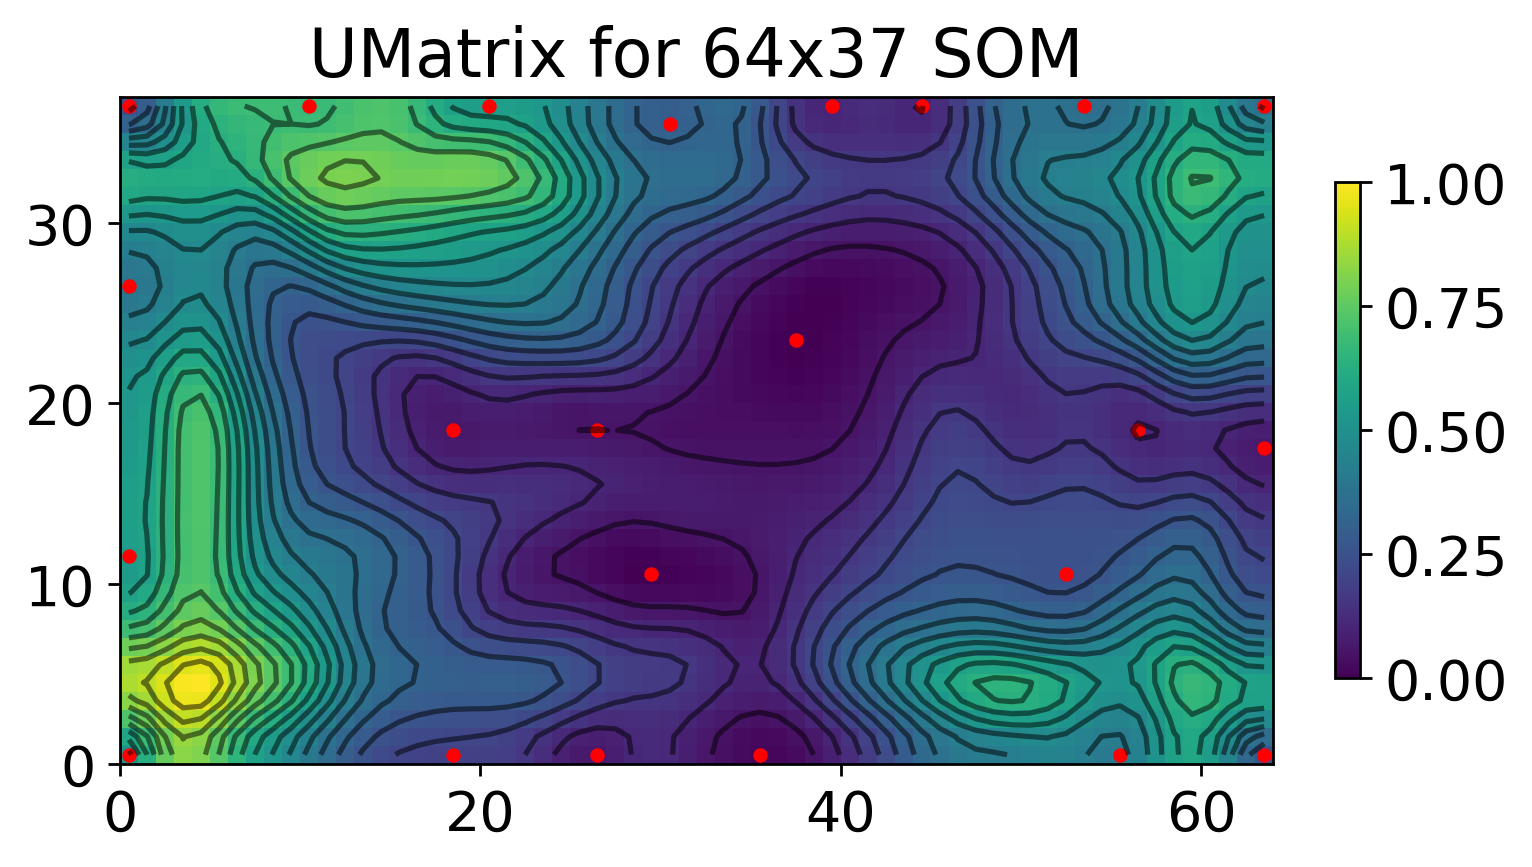

In [22]:
map.umat = map.compute_umat(smoothing=1)
unique_centroids = map.get_unique_centroids(map.compute_centroids())

unique_centroids['position_x'] = [x+0.5 for x in unique_centroids['position_x']]
unique_centroids['position_y'] = [y+0.5 for y in unique_centroids['position_y']]

X,Y = np.meshgrid(np.arange(xdim)+0.5, np.arange(ydim)+0.5)

plt.figure(dpi=250)
plt.pcolormesh(map.umat.T, cmap='viridis')
plt.scatter(unique_centroids['position_x'],unique_centroids['position_y'], color='red', s=10)
plt.colorbar(fraction=0.02)
plt.contour(X, Y, map.umat.T, levels=np.linspace(np.min(map.umat),np.max(map.umat), 20), colors='black', alpha=0.5)
plt.gca().set_aspect("equal")
plt.title(rf'UMatrix for {xdim}x{ydim} SOM')

print('Number of centroids:', len(unique_centroids['position_x']))

U-matrix history

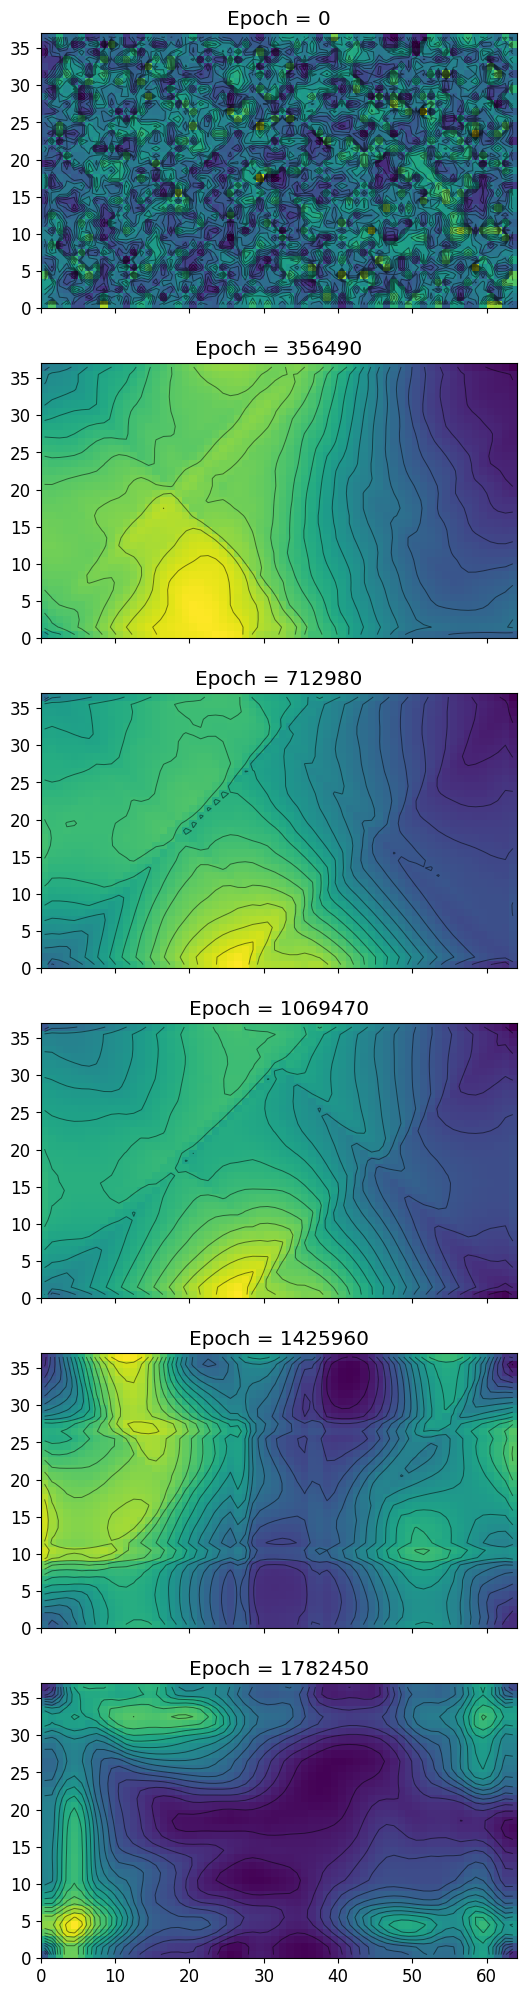

In [3]:
lattice_history = np.array(map.lattice_history)
umat_history = np.array(map.umat_history)
steps = np.linspace(0, lattice_history.shape[0] * map.save_frequency, lattice_history.shape[0], endpoint=False, dtype=int)

xdim = map.xdim
ydim = map.ydim
alpha_0 = map.alpha_0
train = map.train
X,Y = np.meshgrid(np.arange(xdim)+0.5, np.arange(ydim)+0.5)


num_plots = 6
fig, axs = plt.subplots(6, 1, figsize=(10, 25), sharex=True)
fig.subplots_adjust(hspace=0.2)
for i, k in enumerate(range(0, umat_history.shape[0], len(steps)//num_plots+1)):
    umat = umat_history[k]

    axs[i].title.set_text(f'Epoch = {steps[k]}')
    mesh = axs[i].pcolormesh(umat.T, cmap='viridis')
    axs[i].contour(X, Y, umat.T, levels=np.linspace(np.min(umat),np.max(umat), 20), colors='black', alpha=0.5, linewidths=0.7)
    axs[i].set_aspect("equal")


Spider plots to show the relative importance of each feature on the centroids of the identified clusters

In [4]:
plt.rcParams['font.size'] = 18
def plot_centroid_spider(loaded_som_object : Lattice, smoothing : float = None, merge_cost : float = 0.2):
    lattice_values = loaded_som_object.lattice

    # normalize the lattice values around its mean
    lattice_values = np.abs(lattice_values - lattice_values.mean(axis=0))

    mod_lattice_values = np.hstack((lattice_values, lattice_values[:,0].reshape(-1,1)))
    n_features = lattice_values.shape[1]
    features = loaded_som_object.features_names

    dict_lookup = {"j_mag" : r"$j$", "j_par" : r"$j_{\parallel}$", "j_perp" : r"$j_{\perp}$", "j_sym" : r"$j_{\rm s}$", "j_asym" : r"$j_{\rm a}$", "bz" : r"$b_z$", "b_perp" : r"$b_{\perp}$", "e_par" : r"$e_{\parallel}$", "e_perp" : r"$e_{\perp}$"}

    angles = [n / float(n_features) * 2 * np.pi for n in range(n_features)]
    angles += angles[:1]

    loaded_som_object.umat = loaded_som_object.compute_umat(smoothing=smoothing)
    naive_centroids = loaded_som_object.compute_centroids()
    merged_centroids = loaded_som_object.merge_similar_centroids(naive_centroids, threshold=merge_cost)
    unique_centroids = loaded_som_object.get_unique_centroids(merged_centroids)

    unique_centroids_coord = {}

    unique_centroids_coord['position_x'] = [x+0.5 for x in unique_centroids['position_x']]
    unique_centroids_coord['position_y'] = [y+0.5 for y in unique_centroids['position_y']]

    clusters = loaded_som_object.assign_cluster_to_lattice(smoothing=None,merge_cost=merge_cost)
    # numbering_clusters = list(range(len(unique_centroids['position_x'])))

    X,Y = np.meshgrid(np.arange(0,clusters.shape[0],1)+0.5, np.arange(0,clusters.shape[1],1)+0.5)
    dx=10/3
    umat = loaded_som_object.umat

    fig, ax1 = plt.subplots(dpi=300,)
    # ax1.axis('off')
    plt.pcolormesh(clusters.T, cmap='tab10', clim=[0,10], rasterized=True)
    # ax1.pcolormesh(umat.T, cmap='viridis')
    plt.scatter(unique_centroids_coord['position_x'],unique_centroids_coord['position_y'], color='white', s=18)
    # [plt.text(unique_centroids['position_x'][t]+1, unique_centroids['position_y'][t], numbering_clusters[t], color='k', fontsize=10) for t in range(len(numbering_clusters))]
    ax1.contour(X, Y, umat.T, levels=np.linspace(np.min(umat),(np.mean(umat)+np.min(umat))/2, 4), alpha=1, linewidths=0.7, colors='dimgray', linestyles='dotted')
    ax1.contour(X, Y, umat.T, levels=np.linspace((np.mean(umat)+np.min(umat))/2,np.mean(umat), 4), alpha=1, linewidths=0.7, colors='dimgray', linestyles='dashdot')
    ax1.contour(X, Y, umat.T, levels=np.linspace(np.mean(umat),(np.max(umat)+np.mean(umat))/2, 4), alpha=1, linewidths=0.7, colors='dimgray', linestyles='dashed')
    ax1.contour(X, Y, umat.T, levels=np.linspace((np.max(umat)+np.mean(umat))/2,np.max(umat), 4), alpha=1, linewidths=0.7, colors='dimgray', linestyles='solid')
    ax1.set_aspect("equal")
    ax1.set_title(f'{loaded_som_object.xdim}-{loaded_som_object.ydim}-{loaded_som_object.alpha_0}-{loaded_som_object.train} SOM')
    # ax1.set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    # ax1.set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax1.set_xlabel('X (node)')
    ax1.set_ylabel('Y (node)')

    for centroid_id in range(len(unique_centroids['position_x'])):
        row_values_of_centroids = [loaded_som_object.rowix(unique_centroids['position_x'][centroid_id], unique_centroids['position_y'][centroid_id])]
        
        # nrow = 2
        ncol = 3
        pos_x = [0.07, 0.37, 0.67]
        pos_y = [-0.25, -0.65, -1.05, -1.45, -1.85, -2.25]
        # pos_x = [1.1, 1.4, 1.7]
        # pos_y = [0.8, 0.3]
        position_of_subplot = pos_x[centroid_id % ncol], pos_y[centroid_id // ncol], 0.25, 0.25
        if centroid_id == 6:
            position_of_subplot = 0.3, 0.4, 0.25, 0.25
        ax2 = fig.add_axes(position_of_subplot, polar=True)
        ax2.set_xticks(angles[:-1], [dict_lookup[feature] for feature in features], color='black', size=17)
        ax2.set_rlabel_position(0)
        ax2.set_yticks([0, 0.6, 1.2], ["0", "0.6", "1.2"], color="dimgray", size=5)
        ax2.set_ylim(0.0,mod_lattice_values.max())
        # ax2.set_yscale('log')
        ax2.plot(angles, mod_lattice_values[row_values_of_centroids[0]], linewidth=1.5, linestyle='solid', color='black')
        ax2.fill(angles, mod_lattice_values[row_values_of_centroids[0]], 'k', alpha=0.3)
        ax2.set_facecolor(f'C{centroid_id}')
    
    plt.show()

Centroid A: (np.int64(39), np.int64(26)), count: 190
Centroid B: (np.int64(37), np.int64(23)), count: 376
Merging...
Centroid A: (np.int64(44), np.int64(35)), count: 40
Centroid B: (np.int64(39), np.int64(35)), count: 39
Merging...
Centroid A: (np.int64(25), np.int64(19)), count: 47
Centroid B: (np.int64(18), np.int64(18)), count: 400
Merging...
Centroid A: (np.int64(56), np.int64(18)), count: 100
Centroid B: (np.int64(63), np.int64(17)), count: 133
Merging...
Centroid A: (np.int64(35), np.int64(0)), count: 97
Centroid B: (np.int64(26), np.int64(0)), count: 55
Merging...
Centroid A: (np.int64(29), np.int64(10)), count: 259
Centroid B: (np.int64(35), np.int64(0)), count: 152
Merging...
Centroid A: (np.int64(49), np.int64(20)), count: 92
Centroid B: (np.int64(37), np.int64(23)), count: 566
Merging...
Centroid A: (np.int64(29), np.int64(10)), count: 411
Centroid B: (np.int64(37), np.int64(23)), count: 658
Merging...
Centroid A: (np.int64(44), np.int64(35)), count: 79
Centroid B: (np.int64

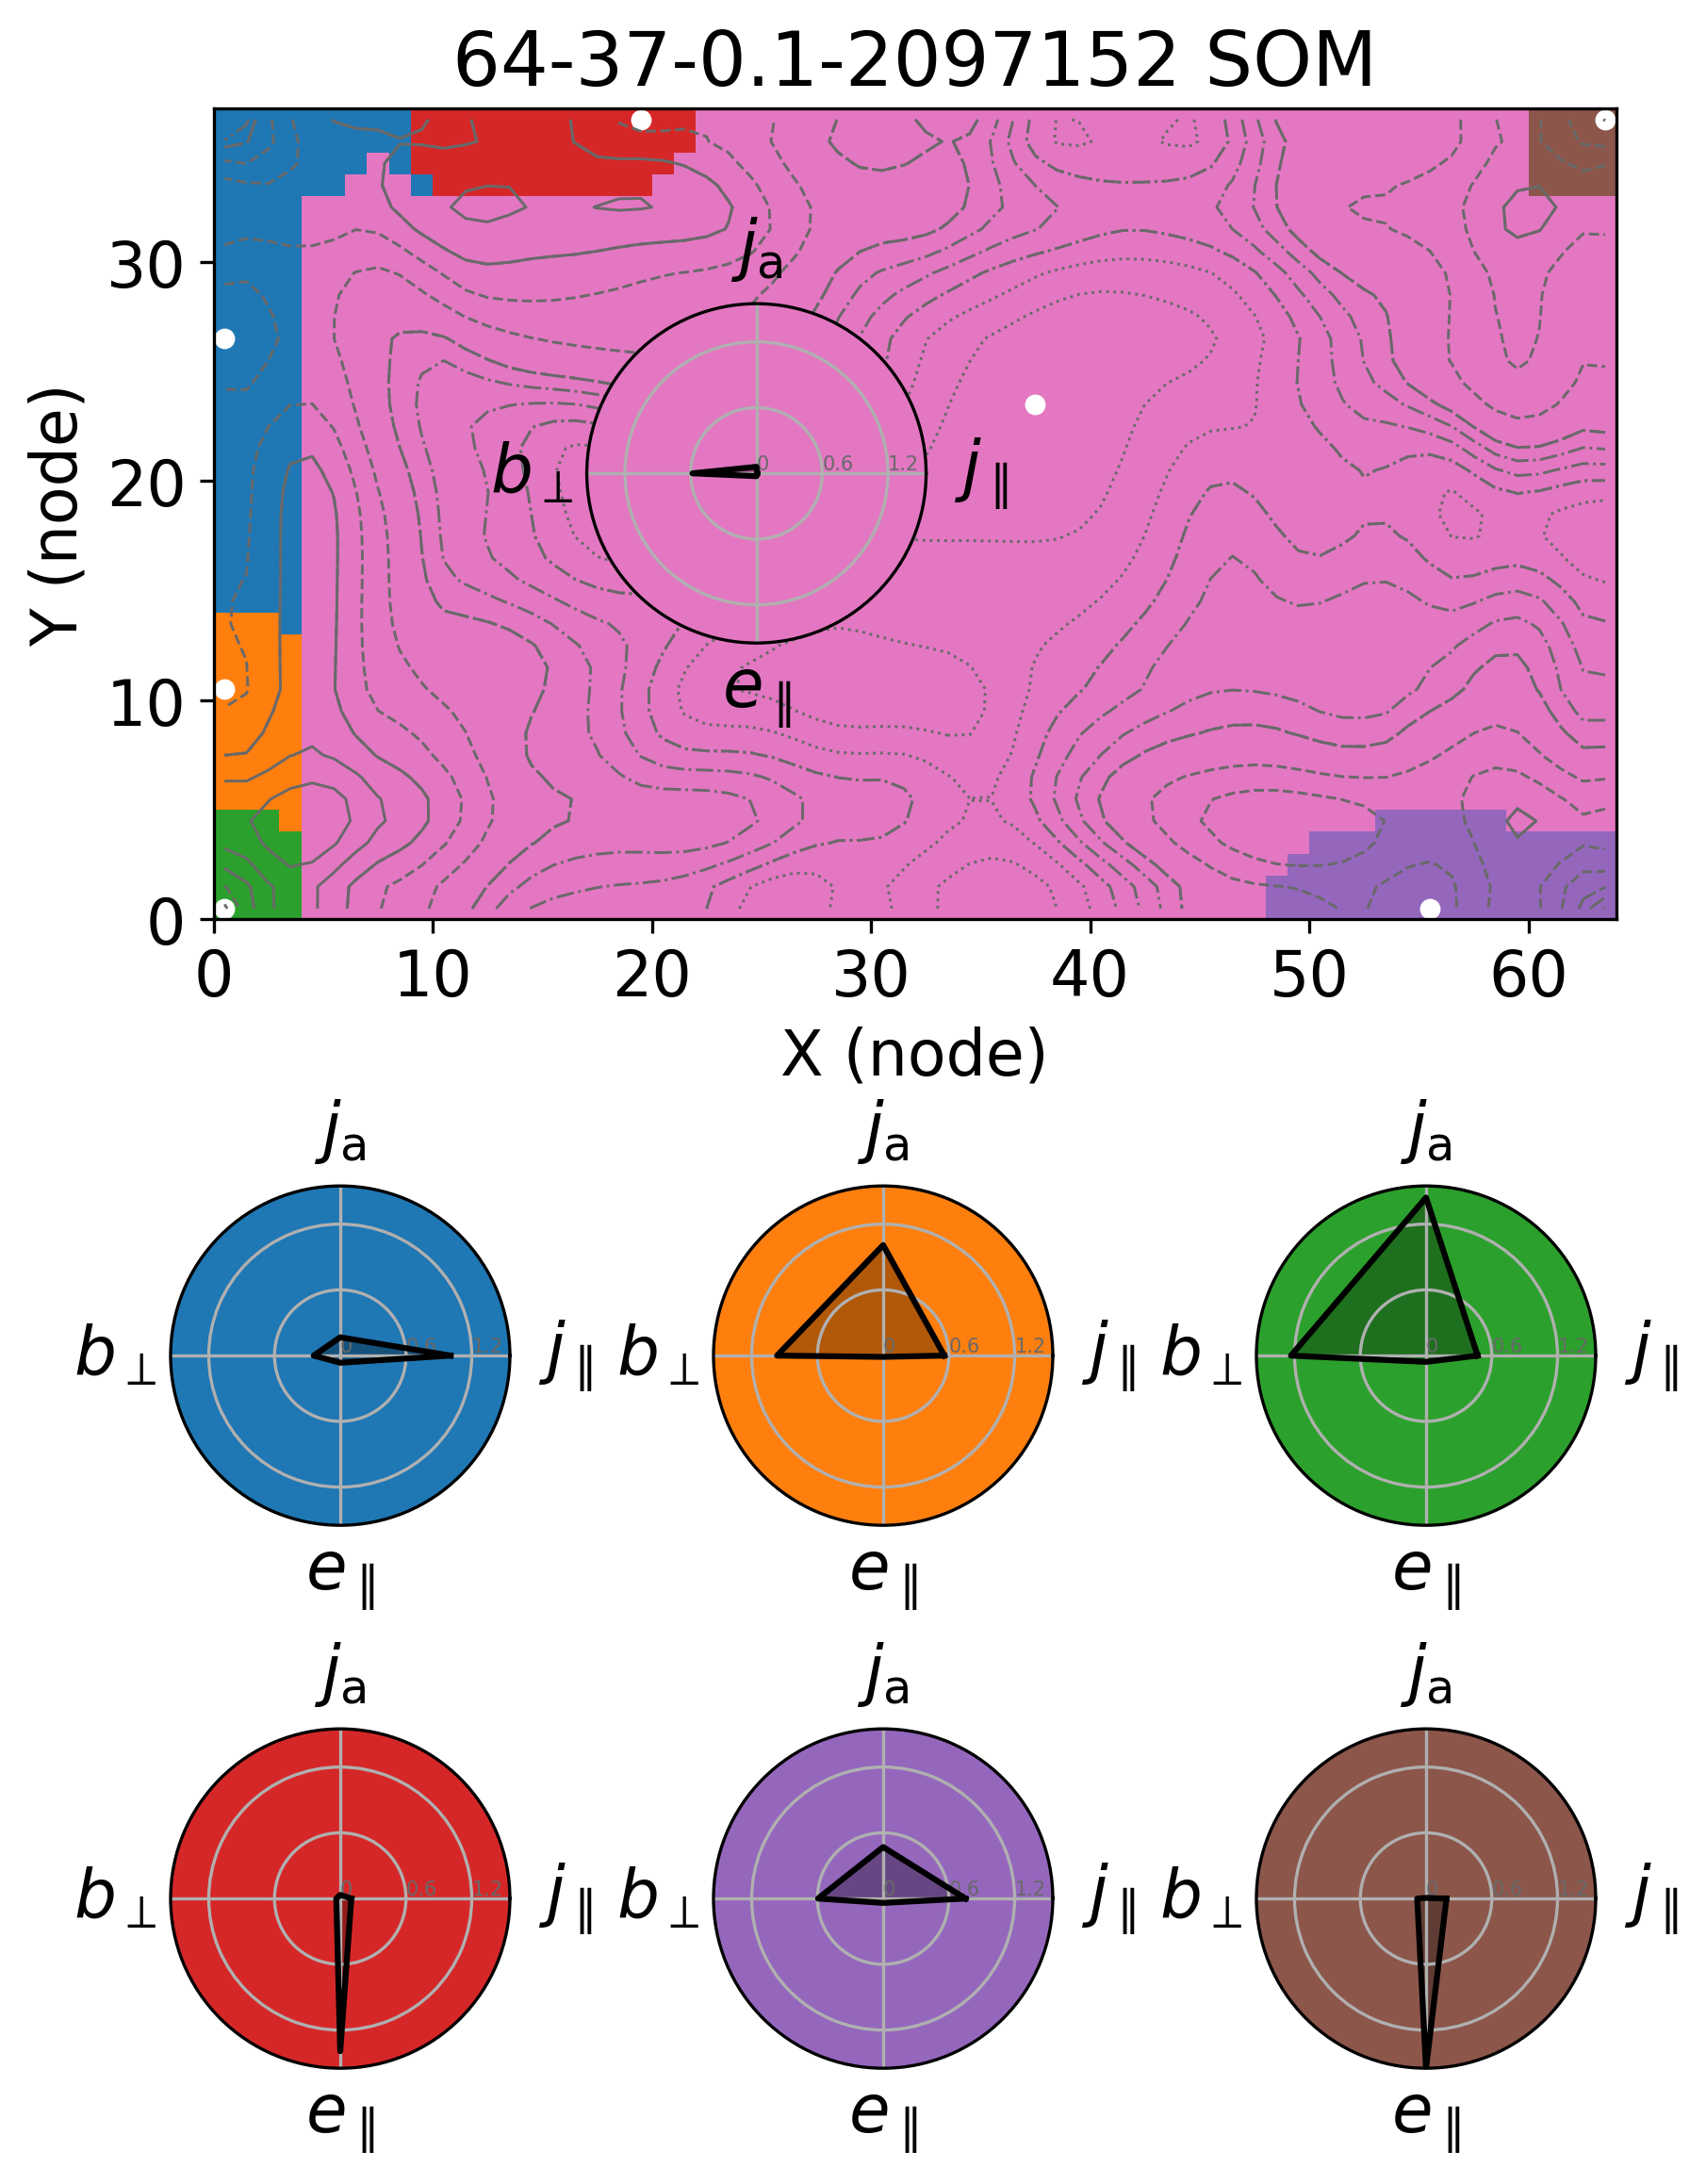

In [26]:
merge_cost = 0.25
smoothing = None # a number or None (cannot be 0)
plot_centroid_spider(map, smoothing=smoothing, merge_cost=merge_cost)

Map SOM result to data

In [27]:
final_clusters = map.assign_cluster_to_lattice(smoothing=smoothing, merge_cost=merge_cost)
som_labels = map.assign_cluster_to_data(map.projection_2d, final_clusters)

Centroid A: (np.int64(39), np.int64(26)), count: 190
Centroid B: (np.int64(37), np.int64(23)), count: 376
Merging...
Centroid A: (np.int64(44), np.int64(35)), count: 40
Centroid B: (np.int64(39), np.int64(35)), count: 39
Merging...
Centroid A: (np.int64(25), np.int64(19)), count: 47
Centroid B: (np.int64(18), np.int64(18)), count: 400
Merging...
Centroid A: (np.int64(56), np.int64(18)), count: 100
Centroid B: (np.int64(63), np.int64(17)), count: 133
Merging...
Centroid A: (np.int64(35), np.int64(0)), count: 97
Centroid B: (np.int64(26), np.int64(0)), count: 55
Merging...
Centroid A: (np.int64(29), np.int64(10)), count: 259
Centroid B: (np.int64(35), np.int64(0)), count: 152
Merging...
Centroid A: (np.int64(49), np.int64(20)), count: 92
Centroid B: (np.int64(37), np.int64(23)), count: 566
Merging...
Centroid A: (np.int64(29), np.int64(10)), count: 411
Centroid B: (np.int64(37), np.int64(23)), count: 658
Merging...
Centroid A: (np.int64(44), np.int64(35)), count: 79
Centroid B: (np.int64

Load simulation data to compare

You need a few things here. First is the original hdf5 snapshot of the simulation, `d3x128s10/flds_5000.h5`, second is the configuration file to read the snapshot, `d3x128s10.ini`. 

Download the files from [link to zenodo archive], then provide the path to the files with `path`.

In [7]:
import read_turbulence_data as rtd
conf = "d3x128s10.ini"
path = "/Users/tvh0021/Documents/Archive/"
filename = "flds_5000.h5"
lap = 5000

decay_turb = rtd.GetH5Data(path, filename, conf, lap)
# get the data
dx = 10./3.
decay_turb.return_basic_j_fields(dx)
decay_turb.return_all_other_fields()

d3x128s10
plotting j_par
flds


/Users/tvh0021/git_repos/aweSOM/examples/plasma-turbulence/initialize_turbulence.py:175: RuntimeWarning: divide by zero encountered in scalar divide
  A = 0.1 * self.g0 / self.gammarad**2  # definition we use in Runko


Visualize the SOM result vs. a xy-slice of the $j_{\parallel}$.

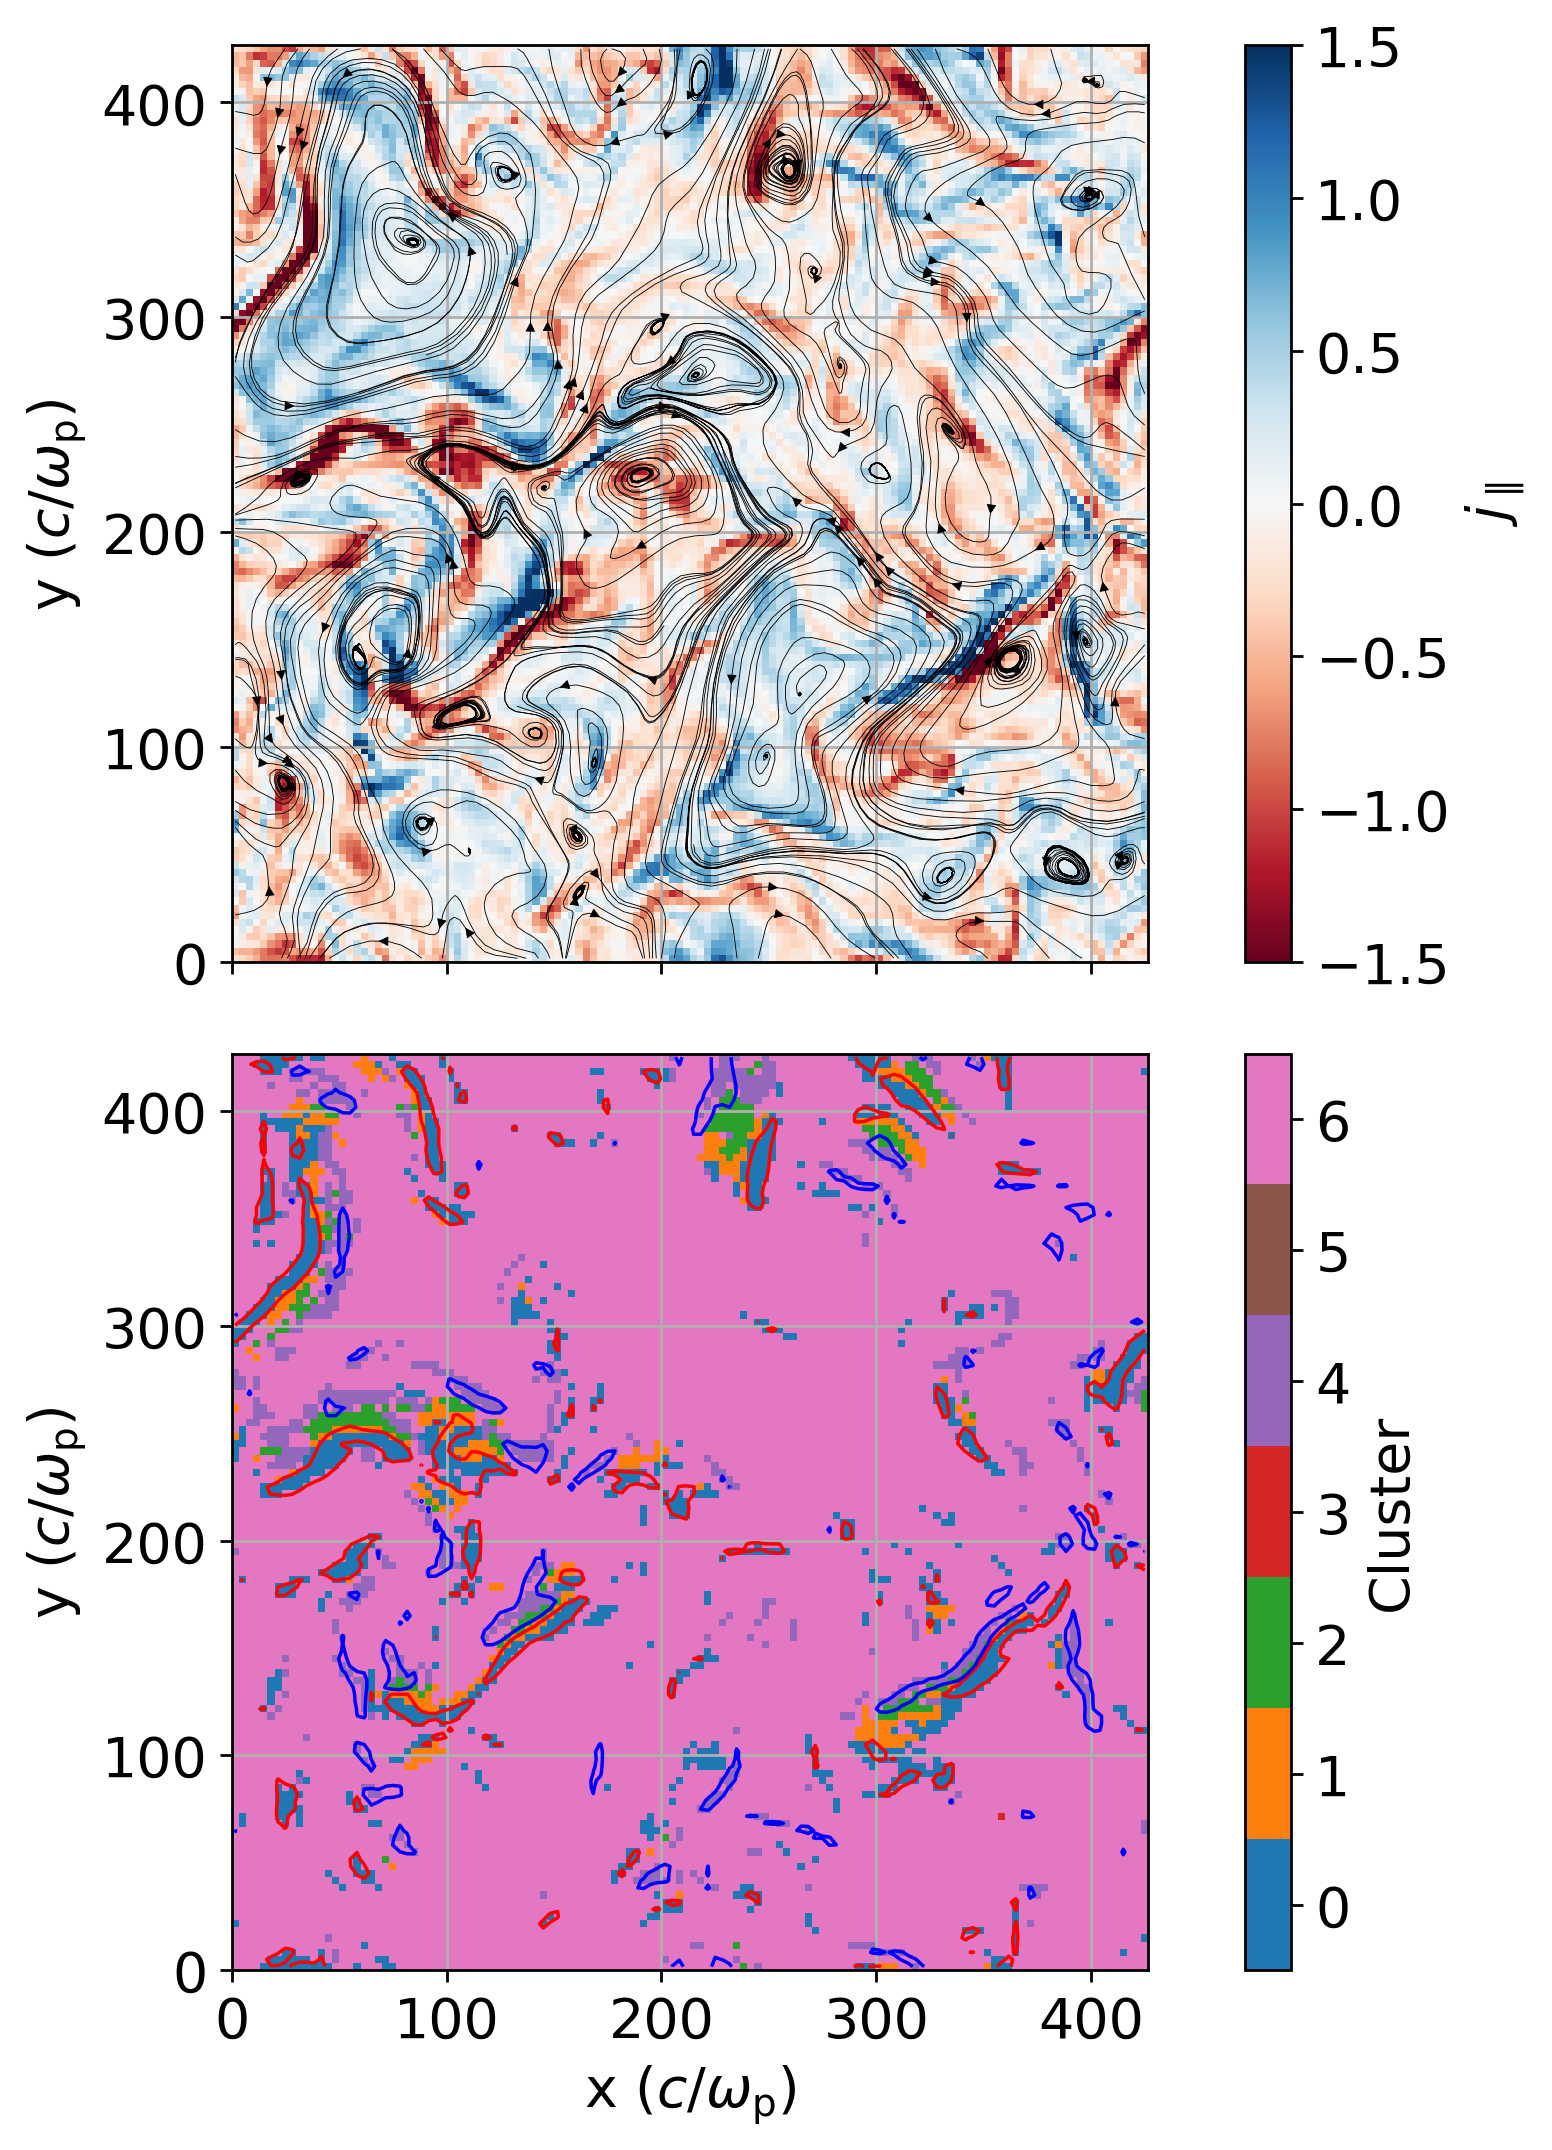

In [30]:
bx = decay_turb.bx
by = decay_turb.by
j_par = decay_turb.j_par
j_par_rms = np.sqrt(np.mean(j_par**2))
nx, ny, nz = decay_turb.nx, decay_turb.ny, decay_turb.nz
som_labels_transformed = som_labels.reshape((nz, ny, nx))

plt.rcParams.update({'font.size': 16})

slice_numbers = [27]

for slice_number in slice_numbers:
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=250, sharex=True)
    fig.subplots_adjust(hspace=0.1)

    jmag_plot = ax[0].pcolormesh(j_par[slice_number], cmap='RdBu', clim=[-1.5,1.5], rasterized=True)
    fig.colorbar(jmag_plot, ax=ax[0], fraction=0.042, pad=0.05, label=r'$j_{\parallel}$', ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5], location="right")
    # ax[0].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors='green', linewidths=1, linestyles='solid')
    ax[0].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1., integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    # fig.colorbar(eperp_plot, ax=ax[0], fraction=0.042, pad=0.04, label=r'$E_{\perp}$', ticks=[0, 0.1, 0.2, 0.3])
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].grid()
    # ax[0].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[0].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    # ax[0].set_xlabel(r'x ($c/\omega_p$)')
    ax[0].set_ylabel(r'y ($c/\omega_{\rm p}$)')
    # ax[0].set_title(f'z = {slice_number*dx:.0f} '+ r'$c/\omega_{\rm p}$')

    cluster_plot = ax[1].pcolormesh(som_labels_transformed[slice_number], cmap='tab10', clim=[0,10], rasterized=True)
    cbar = fig.colorbar(cluster_plot, ax=ax[1], fraction=0.042, pad=0.05, label='Cluster', ticks=np.arange(0, len(set(som_labels)))+0.5, boundaries=np.arange(0, len(set(som_labels))+1), location="right")
    cbar.ax.set_yticklabels(np.arange(0, len(set(som_labels))))
    ax[1].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors=['red','blue'], linewidths=1, linestyles='solid')
    # ax[1].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1, integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].grid()
    ax[1].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_xlabel(r'x ($c/\omega_{\rm p}$)')
    ax[1].set_ylabel(r'y ($c/\omega_{\rm p}$)')

    plt.show()